FONCTIONS

In [1]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
# modèle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# FONCTION 1

def encodage_X(X, type='standard'):
  from sklearn.preprocessing import StandardScaler
  index = X.index
  X_num = X.select_dtypes('number')
  X_cat = X.select_dtypes(['object', 'category', 'string'])

  if type == 'standard':
    from sklearn.preprocessing import StandardScaler
    SN = StandardScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  else:
    from sklearn.preprocessing import MinMaxScaler
    SN = MinMaxScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  # X_dummies = X.drop(columns = X.columns[0:21])
  # X_dummies2 = X_dummies.drop(['prod_FR', 'prod_US'], axis = 1)

  X_num_SN = X_num_SN.mul(poids, axis = 1)
  X_cat_dummies = pd.get_dummies(X_cat)
  X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

  X_encoded = X_encoded.dropna()

  return X_encoded, SN, X_num_SN, X_cat_dummies

# FONCTION 2

def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        from sklearn.neighbors import NearestNeighbors
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# FONCTION 3

def encodage_predict(df_a_predire):
  X_num = df_a_predire.select_dtypes('number')
  X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

  X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)
  X_num_SN = X_num_SN.mul(poids, axis = 1)
  
  X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
  X_encoded_predire = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  df_predict = X_encoded_predire

  # DataFrame vide qui a les mêmes colonnes que X_encoded
  df_final = pd.DataFrame(columns=X_encoded.columns)

  # On veut que le DataFrame ait le même nombre de lignes que df_predict
  df_final = df_final.reindex(index=df_predict.index)
  # On met tous les NaN à False
  df_final = df_final.fillna(False)

  # On parcourt chaque colonne de df_predict
  # Si la colonne est présente dans X_encoded alors on la garde
  # Sinon, on la met à False
  for column in df_predict.columns:
    if column in X_encoded.columns:
      df_final[column] = df_predict[column]

  return df_final

# FONCTION 4

def pokemons_similaires(X, film_id):

  # Vérifier si le Pokémon existe dans le dataset
  if film_id not in X['film_id_out_KNN'].values:
      return f"Le Pokémon {film_id} n'est pas dans le dataset."

  # Récupérer les caractéristiques du Pokémon
  pokemon = X[X['film_id_out_KNN'] == film_id]

  # Je recopie ce qu'on a fait avant:
  caract_pokemon = X[X['film_id_out_KNN'] == film_id]

  caract_pokemon_encoded = encodage_predict(caract_pokemon)

  distances, indices = model.kneighbors(caract_pokemon_encoded)

  return df.iloc[indices[0]].reset_index(drop=True)

IMPORTS

In [3]:
# df = pd.read_csv('BD/P2_G5_films.csv.gz', compression = 'gzip', na_values = ['\\N'])
df = pd.read_csv('BD/P2_G5_films.csv.gz', compression = 'gzip')


FONCTION JONATHAN

FONCTIONS

In [4]:
# CHOIX DES CARACTERISTIQUES

caracteristiques = []

for element in df.columns:
    if 'out_KNN' not in element:
        caracteristiques.append(element)

caracteristiques_num = []

for element in df.select_dtypes(include = 'number').columns:
    if 'out_KNN' not in element:
        caracteristiques_num.append(element)

In [5]:
# METTRE UNIQUEMENT POUR LES COLONNES NUMERIQUES

poids_list = pd.DataFrame(columns = caracteristiques_num, index = ['poids'])

colonne_cle = 1
tres_important = 1
important = 1
bof = 1
rien = 1

poids = {
 'language_fr' : rien,
 'popularity' : colonne_cle,
 'year_exact' : important,
 'Decennie' : colonne_cle,
 'runtime_exact' : rien,
 'vote_exact' : important,
 'arrondi_vote_exact' : colonne_cle,
 'vote_count_mean' : important,
 'prod_US' : important,
 'prod_FR' : important
}

for element in df.select_dtypes(include = 'number').columns:
    if "production_companies_name" in element:
        poids.update({element : important})
    elif "acteur_{" in element:
        poids.update({element : tres_important})
    elif "realisateurs_" in element:
        poids.update({element : tres_important})
    elif "genre_" in element:
        poids.update({element : important})
    else:
         poids.update({element : rien})



for element in poids_list.columns:
    if element not in poids.keys():
        poids.update({element : rien})

In [6]:
# RECHERCHE DU TITRE

df_recherche = df.copy()
df_recherche['title_out_KNN'] = df_recherche['title_out_KNN'].apply(lambda x : x.lower())
recherche = 'star trek'
recherche2 = recherche.lower().split(" ")

for element in recherche2:
    df_recherche2 = df_recherche[df_recherche['title_out_KNN'].str.contains(element)]
    df_recherche = df_recherche2

film_id = df_recherche2['film_id_out_KNN'].iloc[0]

In [7]:
# # RECHERCHE DU REALISATEURS

# df_realisateurs_recherche = pd.DataFrame(df_realisateurs[df_realisateurs['film_id_out_KNN'].str.contains(film_id) == True]['primaryName']).drop_duplicates()
# df_realisateurs_recherche

In [9]:
# BASES

X = df[caracteristiques]

df_a_predire = df[df['film_id_out_KNN'] == film_id]
search = df_a_predire['title_out_KNN'].iloc[0]
# df_a_predire = df_a_predire.drop('title_len_out_KNN', axis = 1)
df_a_predire = df_a_predire[caracteristiques]


k_range = (3,5)

In [ ]:
# FONCTION 1

X_encoded, SN, X_num_SN, X_cat_dummies = encodage_X(X)

# # FONCTION 2

avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# # FONCTION 3

df_final = encodage_predict(df_a_predire)

# # FONCTION 4

# On choisit k
k=4

model = NearestNeighbors(n_neighbors=k, metric='euclidean')
model.fit(X_encoded)

In [1101]:
caracteristiques.append('film_id_out_KNN')
resultat = pokemons_similaires(df[caracteristiques], film_id)
choix = pd.DataFrame(df[df['title_out_KNN'] == search])

# # choix2 = choix.drop(columns = choix.columns[22:])
# # resultat2 = resultat.drop(columns = resultat.columns[22:])

final = pd.concat([choix, resultat])
final = final.drop(0)

caracteristiques.remove('film_id_out_KNN')

final.transpose()

,1665,1,2,3
language_fr,1,1,1,1
popularity,40.244,1.125,0.6,1.4
year_exact,2009.0,2012.0,2022.0,2003.0
Decennie,2000.0,2010.0,2020.0,2000.0
runtime_exact,127.0,89.0,119.0,55.0
...,...,...,...,...
acteur_nm0000168,0,0,0,0
acteur_nm0000461,0,0,0,0
acteur_nm0000945,0,0,0,0
title_debut_out_KNN,startrek,thebigfix,theneighorbood,abbaskiarostamithear


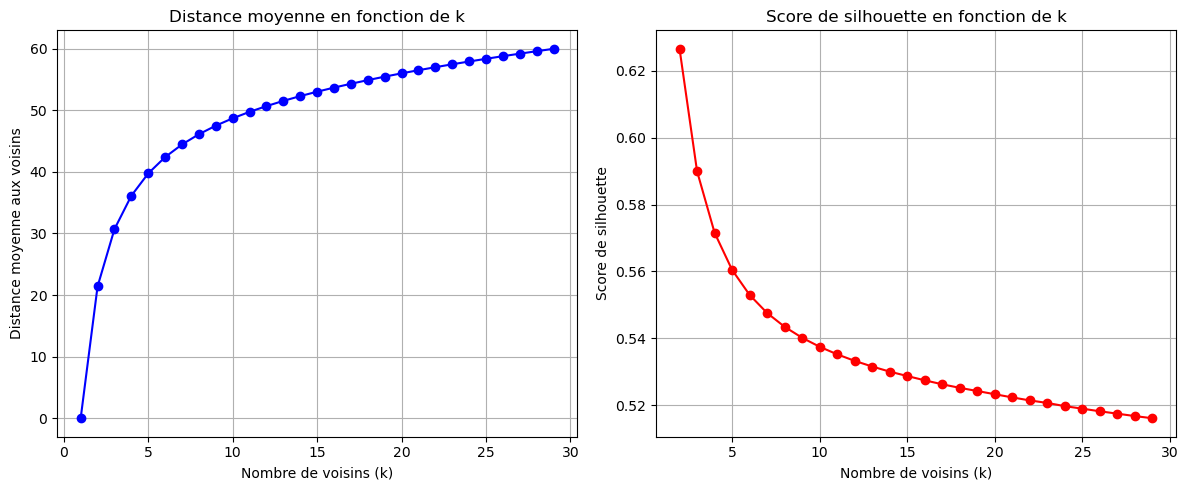

In [1102]:
# Définition de la plage de k à tester

k_range = range(1,30)

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

In [211]:
# X_train, X_test, y_train, y_test = train_test_split(df_films.drop('title_out_KNN', axis=1), df_films['title_out_KNN'], test_size=0.75)

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# param_grid = {"n_neighbors": range(20)}

# # Perform grid search with cross-validation
# gscv = GridSearchCV(model, param_grid, cv=5)
# gscv.fit(X_train, y_train)


# print("Best params:", gscv.best_params_)
# print("Best cross-validation score:", gscv.best_score_)

In [ ]:
# df_films = df.copy()

# df_films['production_companies_name2'] = df_films['production_companies_name'].apply(lambda x: x.replace("[", '').replace("]", '').replace("'", ''))

# df_films['production_companies_name3'] = df_films['production_companies_name2'].apply(lambda x : x.split(','))

# tous_les_genres = set()
# tous_les_genres2 = set()

# for element in df_films['production_companies_name3']:
#   tous_les_genres.update(element)

# tous_les_genres_list = list(tous_les_genres)

# tous_les_genres_list.remove("")

# for n in range(len(tous_les_genres_list)):
#   tous_les_genres_list[n] = tous_les_genres_list[n].replace(" ","")

# tous_les_genres2_list = list(tous_les_genres2)
# tous_les_genres2_list.remove("")

# df_films['production_companies_name4'] = df_films['production_companies_name'].apply(lambda x: x.replace(" ", ''))

# new_dict = {}

# for element in tous_les_genres_list:
#     if len(df_films[df_films['production_companies_name2'].str.contains(element) == True]) >= 500:
#       new_dict.update({element : len(df_films[df_films['production_companies_name2'].str.contains(element) == True])})

# new_dict_sorted = dict(sorted(new_dict.items(), key=lambda x:x[1]))

# for genre in new_dict_sorted.keys():
#   df_films[f'production_companies_name_{genre}'] = df_films['production_companies_name4'].apply(lambda x: genre in x)

In [ ]:
# df_LN = df[df['vote_count_mean'] != 0].drop(['adult', 'production_countries', 'status', 'tagline', 'production_companies_name', 'production_companies_country', 'titleType', 'region', 'Decennie', 'genre', 'final_language', 'popularity', 'year_exact', 'runtime_exact', 'vote_exact', 'arrondi_vote_exact', 'vote_count_mean'], axis = 1)
# df_LN_drop_NA = df_LN.dropna()
# X = df_LN_drop_NA
# y = pd.DataFrame(df_LN_drop_NA)

# def encodage_X(X, type='standard'):
#   X_num = X.select_dtypes('number')
#   X_cat = X.select_dtypes(['object', 'category', 'string'])
#   # Comme ça les dates, on n'y touche pas

#   if type == 'standard':
#     from sklearn.preprocessing import StandardScaler
#     SN = StandardScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   else:
#     from sklearn.preprocessing import MinMaxScaler
#     SN = MinMaxScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   X_cat_dummies = pd.get_dummies(X_cat)
#   X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   return X_encoded, SN

# X_encoded, SN = encodage_X(X)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8)

# from sklearn.linear_model import LinearRegression

# modele = LinearRegression()

# modele.fit(X_train, y_train)

# print(f"Score d'entrainement {modele.score(X_train, y_train)}")
# print(f"Score de test {modele.score(X_test, y_test)}")

# df_a_predire = df_test[df_test['vote_count_mean'] == 0].drop(['isOriginalTitle', 'ordering', 'film_id', 'id', 'revenue', 'budget', 'backdrop_path', 'homepage', 'overview', 'poster_path', 'status', 'tagline', 'video', 'titleType', 'types', 'attributes'], axis = 1)
# df_a_predire = df_a_predire.drap('vote_count_mean', axis = 1)
# df_quelonveutpredire = df_a_predire.dropna()

# def encodage_predict(df_a_predire):
#   X_num = df_a_predire.select_dtypes('number')
#   X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

#   X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

#   X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
#   X_encoded_predire = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   df_predict = X_encoded_predire

#   # DataFrame vide qui a les mêmes colonnes que X_encoded
#   df_final = pd.DataFrame(columns=X_encoded.columns)

#   # On veut que le DataFrame ait le même nombre de lignes que df_predict
#   df_final = df_final.reindex(index=df_predict.index)
#   # On met tous les NaN à False
#   df_final = df_final.fillna(False)

#   # On parcourt chaque colonne de df_predict
#   # Si la colonne est présente dans X_encoded alors on la garde
#   # Sinon, on la met à False
#   for column in df_predict.columns:
#     if column in X_encoded.columns:
#       df_final[column] = df_predict[column]

#   return df_final

# df_pour_prediction = encodage_predict(df_quelonveutpredire)

# df_quelonveutpredire['prediction'] = modele.predict(df_pour_prediction)
# df_quelonveutpredire
